## pygad library utilized GA

In [54]:
import numpy as np
import pygad
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd


## Step 1: Data Preparation

In [55]:
# Fetch real historical data from Yahoo Finance
num_assets = 5
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Download the adjusted closing prices for the selected tickers
data = yf.download(tickers, start="2020-01-01", end="2024-01-01")['Adj Close']

data

[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2020-01-02 00:00:00+00:00,72.796021,94.900497,68.186813,153.630707,28.684000
2020-01-03 00:00:00+00:00,72.088295,93.748497,67.830109,151.717743,29.534000
2020-01-06 00:00:00+00:00,72.662727,95.143997,69.638054,152.109894,30.102667
2020-01-07 00:00:00+00:00,72.320969,95.343002,69.503548,150.722992,31.270666
2020-01-08 00:00:00+00:00,73.484329,94.598503,69.998253,153.123764,32.809334
...,...,...,...,...,...
2023-12-22 00:00:00+00:00,192.656174,153.419998,140.978943,371.799713,252.539993
2023-12-26 00:00:00+00:00,192.108856,153.410004,141.008835,371.879120,256.609985
2023-12-27 00:00:00+00:00,192.208374,153.339996,139.862976,371.293518,261.440002


In [56]:
# Drop tickers that failed to download
data = data.dropna(axis=1, how='all')

In [57]:
data

Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2020-01-02 00:00:00+00:00,72.796021,94.900497,68.186813,153.630707,28.684000
2020-01-03 00:00:00+00:00,72.088295,93.748497,67.830109,151.717743,29.534000
2020-01-06 00:00:00+00:00,72.662727,95.143997,69.638054,152.109894,30.102667
2020-01-07 00:00:00+00:00,72.320969,95.343002,69.503548,150.722992,31.270666
2020-01-08 00:00:00+00:00,73.484329,94.598503,69.998253,153.123764,32.809334
...,...,...,...,...,...
2023-12-22 00:00:00+00:00,192.656174,153.419998,140.978943,371.799713,252.539993
2023-12-26 00:00:00+00:00,192.108856,153.410004,141.008835,371.879120,256.609985
2023-12-27 00:00:00+00:00,192.208374,153.339996,139.862976,371.293518,261.440002


In [58]:
# Update the number of assets to reflect actual data downloaded
num_assets = data.shape[1]
tickers = data.columns.tolist()

# Calculate the returns for ML prediction
data_returns = data.pct_change().dropna()

In [59]:
data_returns

Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2020-01-03 00:00:00+00:00,-0.009722,-0.012139,-0.005231,-0.012452,0.029633
2020-01-06 00:00:00+00:00,0.007968,0.014886,0.026654,0.002585,0.019255
2020-01-07 00:00:00+00:00,-0.004703,0.002092,-0.001932,-0.009118,0.038801
2020-01-08 00:00:00+00:00,0.016086,-0.007809,0.007118,0.015928,0.049205
2020-01-09 00:00:00+00:00,0.021241,0.004799,0.010498,0.012493,-0.021945
...,...,...,...,...,...
2023-12-22 00:00:00+00:00,-0.005548,-0.002730,0.007620,0.002784,-0.007701
2023-12-26 00:00:00+00:00,-0.002841,-0.000065,0.000212,0.000214,0.016116
2023-12-27 00:00:00+00:00,0.000518,-0.000456,-0.008126,-0.001575,0.018822


## Step 2: Machine Learning - Predict Expected Returns

In [60]:
# Prepare data for ML model
X = []
y = []
window_size = 30  # Use past 30 days to predict the next day return

for i in range(window_size, len(data_returns) - 1):
    X.append(data_returns.iloc[i - window_size:i].values.flatten())
    y.append(data_returns.iloc[i + 1].values)

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor model to predict returns
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict returns for the latest available data
predicted_returns = model.predict([data_returns.iloc[-window_size:].values.flatten()])[0]
print(f"Predicted Returns: {predicted_returns}")

Predicted Returns: [0.00323942 0.00308629 0.00305905 0.00172381 0.00534653]


## Step 3: Fitness Function 

In [61]:
def fitness_function(ga_instance, solution, solution_idx):
    try:
        # Ensure sum of weights approximately equals 1
        if not 0.98 <= np.sum(solution) <= 1.02:
            penalty = abs(np.sum(solution) - 1) * 10  # Penalize solutions that deviate too much
            return -penalty

        # Ensure minimum allocation constraint
        if np.any(solution < 0.05):
            penalty = -np.sum(solution[solution < 0.05]) * 20  # Stronger penalty for solutions with less than 5% allocation to any asset
            return -penalty

        # Calculate portfolio return using predicted returns
        portfolio_return = np.sum(solution * predicted_returns)

        # Calculate portfolio variance using covariance matrix
        cov_matrix = data_returns.cov().values
        portfolio_variance = np.dot(solution.T, np.dot(cov_matrix, solution))
        portfolio_risk = np.sqrt(portfolio_variance)

        # Risk Threshold
        max_risk_threshold = 0.35
        if portfolio_risk > max_risk_threshold:
            penalty = (portfolio_risk - max_risk_threshold) * 10
            return -penalty

        # Calculate Sharpe Ratio (assuming risk-free rate of 2%)
        sharpe_ratio = (portfolio_return - 0.02) / portfolio_risk

        # Reward diversification: encourage more assets to have non-zero allocations
        num_nonzero_allocations = np.count_nonzero(solution)
        diversification_reward = num_nonzero_allocations / num_assets

        # Penalty for large variance in allocation (encourage balanced weights)
        variance_penalty = np.var(solution) * 5  # Tuned factor to control emphasis on balanced allocations

        # Encourage balance by adding a reward for solutions that have more even distribution among assets
        allocation_balance_reward = -np.std(solution)  # Reward lower standard deviation in allocations

        # Calculate fitness by combining different components
        fitness_value = sharpe_ratio + diversification_reward - variance_penalty + allocation_balance_reward

        # Clip fitness values to avoid very small values
        fitness_value = max(fitness_value, 1e-6)

        return fitness_value

    except Exception as e:
        print(f"Error calculating fitness for solution {solution_idx}: {e}")
        return -10  # Penalize any solution that fails

## Step 4: Normalize Solutions

In [62]:
def normalize_solution(solution):
    total = np.sum(solution)
    if total == 0:
        return np.full_like(solution, 1.0 / len(solution))
    return solution / total

## Step 5: Set Up GA with Early Stopping and Multiple Runs

In [63]:
num_runs = 4  # Number of GA runs to plot different curves
colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Colors for each run

# Lists to store best fitness evolution, solutions, and early stopping generations from all runs
all_best_fitness_values = []
all_best_solutions = []
all_best_fitness_overall = []
early_stopping_generations = []

for run in range(num_runs):
    best_fitness_values = []
    average_fitness_values = []
    best_solution_overall = None
    best_solution_fitness = -np.inf

    def normalize_population(ga_instance):
        global best_fitness_values, average_fitness_values, best_solution_overall, best_solution_fitness

        # Normalize solutions
        for i in range(ga_instance.sol_per_pop):
            ga_instance.population[i] = normalize_solution(ga_instance.population[i])

        fitness_values = [fitness_function(ga_instance, solution, idx) for idx, solution in enumerate(ga_instance.population)]
        best_fitness = np.max(fitness_values)
        average_fitness = np.mean(fitness_values)

        # Update the best solution overall if the current best is better
        if best_fitness > best_solution_fitness:
            best_solution_overall = ga_instance.population[np.argmax(fitness_values)]
            best_solution_fitness = best_fitness

        best_fitness_values.append(best_fitness)
        average_fitness_values.append(average_fitness)

        # Early stopping if fitness values have plateaued
        if len(best_fitness_values) > 30 and np.std(best_fitness_values[-30:]) < 1e-6:
            early_stopping_generations.append(ga_instance.generations_completed)
            return "stop"

        print(f"Generation {ga_instance.generations_completed} completed with best fitness: {best_fitness}")

    # Set up and run the Genetic Algorithm for each run
    ga_instance = pygad.GA(num_generations=400,
                           num_parents_mating=30,
                           fitness_func=fitness_function,
                           sol_per_pop=100,
                           num_genes=num_assets,
                           init_range_low=0,
                           init_range_high=1,
                           parent_selection_type="tournament",
                           crossover_type="uniform",  # Switched to uniform crossover
                           crossover_probability=0.8,
                           mutation_type="random",
                           mutation_percent_genes=25,  # Increased mutation rate
                           gene_space=[{'low': 0, 'high': 1} for _ in range(num_assets)],
                           on_generation=normalize_population,
                           keep_elitism=2)

    ga_instance.run()

    # If early stopping didn't happen, record the total number of generations
    if len(early_stopping_generations) < run + 1:
        early_stopping_generations.append(ga_instance.generations_completed)

    # Store the results of the run
    all_best_fitness_values.append(best_fitness_values)
    all_best_solutions.append(best_solution_overall)
    all_best_fitness_overall.append(best_solution_fitness)

/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/Computational Intelligence/CW/portfolio_optimization_in_finance/.venv/lib/python3.8/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation 1 completed with best fitness: 1.7764998695088479
Generation 2 completed with best fitness: 1.5362768636437605
Generation 3 completed with best fitness: 2.590195433112983
Generation 4 completed with best fitness: 1.3405820151950492
Generation 5 completed with best fitness: 1.6835636280740127
Generation 6 completed with best fitness: 1.141024374990362
Generation 7 completed with best fitness: 2.1688022259475876
Generation 8 completed with best fitness: 1.5153308966981704
Generation 9 completed with best fitness: 1.3985054266691455
Generation 10 completed with best fitness: 1.6489886186565883
Generation 11 completed with best fitness: 1.387383987892725
Generation 12 completed with best fitness: 1.631044868523821
Generation 13 completed with best fitness: 1.9401012361208283
Generation 14 completed with best fitness: 1.6681197526291678
Generation 15 completed with best fitness: 1.8940016942487168
Generation 16 completed with best fitness: 1.5916512351694894
Generation 17 complet

## Output the Best Solution Found Overall for Each Run and Early Stopping Generation

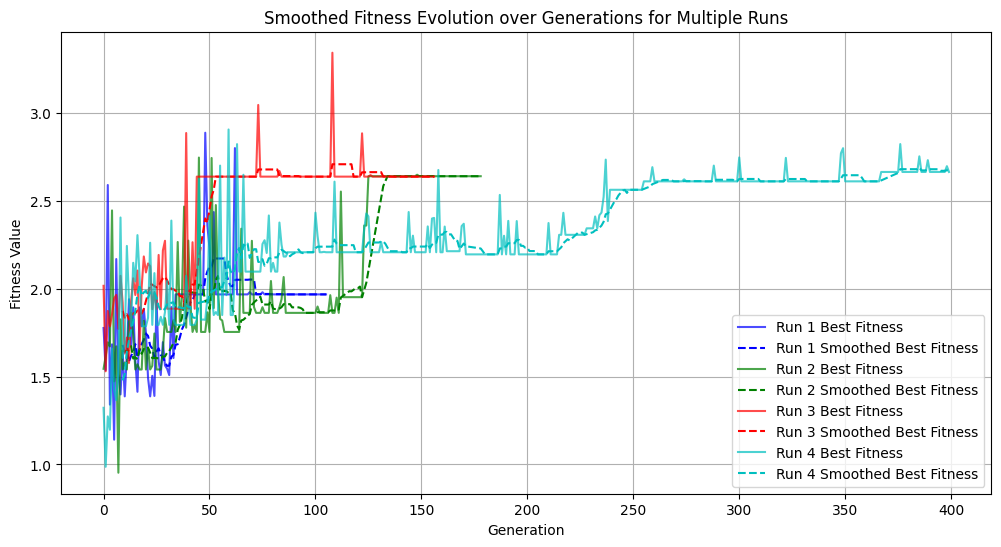

Run 1 Best Portfolio: [0.05860137 0.07423788 0.51655555 0.06767069 0.2829345 ]
Run 1 Fitness (Sharpe Ratio + Diversification Reward): 2.8875792458843175
Run 1 Stopped at Generation: 106

Run 2 Best Portfolio: [0.67007806 0.0180047  0.24905967 0.05057307 0.01228449]
Run 2 Fitness (Sharpe Ratio + Diversification Reward): 2.746296394501973
Run 2 Stopped at Generation: 179

Run 3 Best Portfolio: [0.01809574 0.30538169 0.16575487 0.         0.51076769]
Run 3 Fitness (Sharpe Ratio + Diversification Reward): 3.3428303206639858
Run 3 Stopped at Generation: 157

Run 4 Best Portfolio: [0.14806517 0.16840469 0.02789626 0.41703979 0.23859409]
Run 4 Fitness (Sharpe Ratio + Diversification Reward): 2.9060540020783616
Run 4 Stopped at Generation: 400



In [64]:
plt.figure(figsize=(12, 6))
for run in range(num_runs):
    smoothed_best_fitness = pd.Series(all_best_fitness_values[run]).rolling(window=10).mean()
    plt.plot(all_best_fitness_values[run], color=colors[run], linestyle='-', alpha=0.7, label=f"Run {run + 1} Best Fitness")
    plt.plot(smoothed_best_fitness, color=colors[run], linestyle='--', label=f"Run {run + 1} Smoothed Best Fitness")

plt.xlabel("Generation")
plt.ylabel("Fitness Value")
plt.title("Smoothed Fitness Evolution over Generations for Multiple Runs")
plt.legend()
plt.grid(True)
plt.show()

for run in range(num_runs):
    print(f"Run {run + 1} Best Portfolio: {all_best_solutions[run]}")
    print(f"Run {run + 1} Fitness (Sharpe Ratio + Diversification Reward): {all_best_fitness_overall[run]}")
    print(f"Run {run + 1} Stopped at Generation: {early_stopping_generations[run]}\n")


## Batch wise execution

Starting Run 1
  Batch 1/4 for Run 1
    Batch 1 Best Fitness: 2.7917532526408206
  Batch 2/4 for Run 1
    Batch 2 Best Fitness: 3.279222005872417
  Batch 3/4 for Run 1
    Batch 3 Best Fitness: 3.279222005872417
  Batch 4/4 for Run 1
    Batch 4 Best Fitness: 3.3261465431674884
Starting Run 2
  Batch 1/4 for Run 2
    Batch 1 Best Fitness: 2.551164714114921
  Batch 2/4 for Run 2
    Batch 2 Best Fitness: 2.868074597199106
  Batch 3/4 for Run 2
    Batch 3 Best Fitness: 2.868074597199106
  Batch 4/4 for Run 2
    Batch 4 Best Fitness: 3.1105537054779226
Starting Run 3
  Batch 1/4 for Run 3
    Batch 1 Best Fitness: 2.535542921349483
  Batch 2/4 for Run 3
    Batch 2 Best Fitness: 2.800348336169791
  Batch 3/4 for Run 3
    Batch 3 Best Fitness: 2.9349010721477855
  Batch 4/4 for Run 3
    Batch 4 Best Fitness: 2.9349010721477855
Starting Run 4
  Batch 1/4 for Run 4
    Batch 1 Best Fitness: 3.5389697684074917
  Batch 2/4 for Run 4
    Batch 2 Best Fitness: 3.6117001572649263
  Batch 3

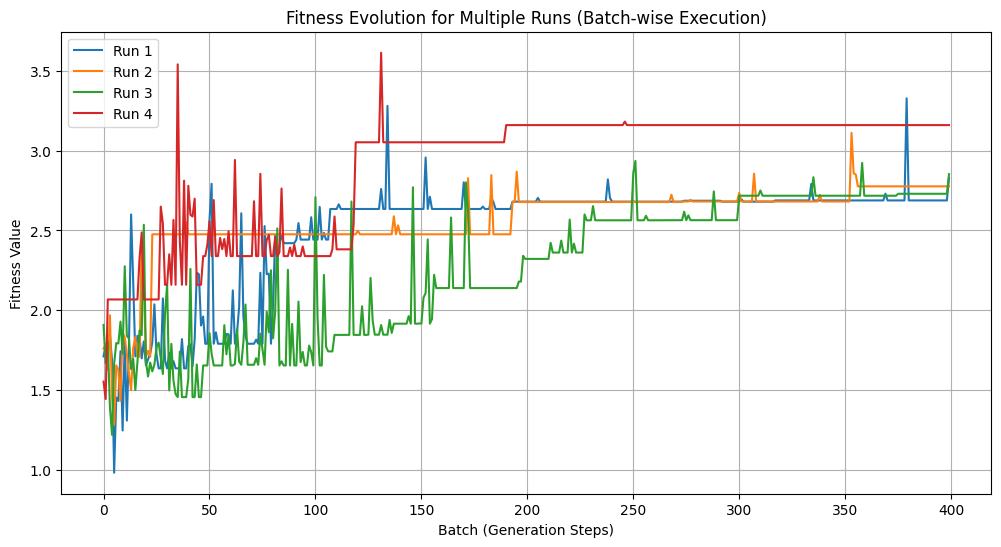

Run 1 Best Portfolio: [0.0259444  0.         0.29957094 0.23603793 0.43844673]
Run 1 Fitness (Sharpe Ratio + Diversification Reward): 3.3261465431674884
Run 1 Stopped at Generation: 106

Run 2 Best Portfolio: [0.1374834  0.16567435 0.33078923 0.2891763  0.07687672]
Run 2 Fitness (Sharpe Ratio + Diversification Reward): 3.1105537054779226
Run 2 Stopped at Generation: 179

Run 3 Best Portfolio: [0.32933185 0.42610628 0.0365088  0.03714797 0.17090509]
Run 3 Fitness (Sharpe Ratio + Diversification Reward): 2.9349010721477855
Run 3 Stopped at Generation: 157

Run 4 Best Portfolio: [0.23710907 0.         0.24283418 0.20002148 0.32003527]
Run 4 Fitness (Sharpe Ratio + Diversification Reward): 3.6117001572649263
Run 4 Stopped at Generation: 400



In [65]:
# Step 3: Define Fitness Function (with balancing adjustment)
def fitness_function(ga_instance, solution, solution_idx):
    try:
        # Ensure sum of weights approximately equals 1
        if not 0.98 <= np.sum(solution) <= 1.02:
            penalty = abs(np.sum(solution) - 1) * 10  # Penalize solutions that deviate too much
            return -penalty

        # Ensure minimum allocation constraint
        if np.any(solution < 0.05):
            penalty = -np.sum(solution[solution < 0.05]) * 20  # Stronger penalty for solutions with less than 5% allocation to any asset
            return -penalty

        # Calculate portfolio return using predicted returns
        portfolio_return = np.sum(solution * predicted_returns)

        # Calculate portfolio variance using covariance matrix
        cov_matrix = data_returns.cov().values
        portfolio_variance = np.dot(solution.T, np.dot(cov_matrix, solution))
        portfolio_risk = np.sqrt(portfolio_variance)

        # Risk Threshold
        max_risk_threshold = 0.35
        if portfolio_risk > max_risk_threshold:
            penalty = (portfolio_risk - max_risk_threshold) * 10
            return -penalty

        # Calculate Sharpe Ratio (assuming risk-free rate of 2%)
        sharpe_ratio = (portfolio_return - 0.02) / portfolio_risk

        # Reward diversification: encourage more assets to have non-zero allocations
        num_nonzero_allocations = np.count_nonzero(solution)
        diversification_reward = num_nonzero_allocations / num_assets

        # Penalty for large variance in allocation (encourage balanced weights)
        variance_penalty = np.var(solution) * 5  # Tuned factor to control emphasis on balanced allocations

        # Encourage balance by adding a reward for solutions that have more even distribution among assets
        allocation_balance_reward = -np.std(solution)  # Reward lower standard deviation in allocations

        # Calculate fitness by combining different components
        fitness_value = sharpe_ratio + diversification_reward - variance_penalty + allocation_balance_reward

        # Clip fitness values to avoid very small values
        fitness_value = max(fitness_value, 1e-6)

        return fitness_value

    except Exception as e:
        print(f"Error calculating fitness for solution {solution_idx}: {e}")
        return -10  # Penalize any solution that fails


# Step 4: Normalize Solutions
def normalize_solution(solution):
    total = np.sum(solution)
    if total == 0:
        return np.full_like(solution, 1.0 / len(solution))
    return solution / total


# Step 5: Set Up GA with Early Stopping and Multiple Runs
num_runs = 4  # Number of GA runs to plot different curves
colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Colors for each run

# Batching Parameters
total_generations = 400  # Total number of generations
batch_size = 100         # Number of generations per batch
num_batches = total_generations // batch_size  # Total batches
num_runs = 4             # Number of runs (batch-wise execution repeated for robustness)

# Storage for all runs
all_best_fitness_values = []
all_best_solutions = []
all_best_fitness_overall = []

for run in range(num_runs):
    print(f"Starting Run {run + 1}")
    
    best_fitness_values = []
    best_solution_overall = None
    best_solution_fitness = -np.inf

    def normalize_population(ga_instance):
        global best_fitness_values, best_solution_overall, best_solution_fitness

        # Normalize portfolio weights
        for i in range(ga_instance.sol_per_pop):
            ga_instance.population[i] = normalize_solution(ga_instance.population[i])

        fitness_values = [fitness_function(ga_instance, solution, idx) 
                          for idx, solution in enumerate(ga_instance.population)]
        best_fitness = np.max(fitness_values)

        # Track the best solution so far
        if best_fitness > best_solution_fitness:
            best_solution_overall = ga_instance.population[np.argmax(fitness_values)]
            best_solution_fitness = best_fitness

        best_fitness_values.append(best_fitness)

    # Initialize Genetic Algorithm
    ga_instance = pygad.GA(num_generations=batch_size,  # Run batch-sized generations
                           num_parents_mating=30,
                           fitness_func=fitness_function,
                           sol_per_pop=100,
                           num_genes=num_assets,
                           init_range_low=0,
                           init_range_high=1,
                           parent_selection_type="tournament",
                           crossover_type="uniform",
                           crossover_probability=0.8,
                           mutation_type="random",
                           mutation_percent_genes=25,
                           gene_space=[{'low': 0, 'high': 1} for _ in range(num_assets)],
                           on_generation=normalize_population,
                           keep_elitism=2)

    # Run the GA in batches
    for batch in range(num_batches):
        print(f"  Batch {batch + 1}/{num_batches} for Run {run + 1}")
        ga_instance.run()  # Execute one batch
        
        # Display intermediate results
        print(f"    Batch {batch + 1} Best Fitness: {np.max(best_fitness_values)}")

    # Store results for this run
    all_best_fitness_values.append(best_fitness_values)
    all_best_solutions.append(best_solution_overall)
    all_best_fitness_overall.append(best_solution_fitness)

# Visualization of Results
plt.figure(figsize=(12, 6))
for run in range(num_runs):
    plt.plot(all_best_fitness_values[run], label=f"Run {run + 1}")
plt.xlabel("Batch (Generation Steps)")
plt.ylabel("Fitness Value")
plt.title("Fitness Evolution for Multiple Runs (Batch-wise Execution)")
plt.legend()
plt.grid()
plt.show()

# Final Results
for run in range(num_runs):
    print(f"Run {run + 1} Best Portfolio: {all_best_solutions[run]}")
    print(f"Run {run + 1} Fitness (Sharpe Ratio + Diversification Reward): {all_best_fitness_overall[run]}")
    print(f"Run {run + 1} Stopped at Generation: {early_stopping_generations[run]}\n")
